# Test set evaluation of Gender image classification models

## UTKFace dataset

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score

In [2]:
from keras import backend as K
K.clear_session()

In [3]:
# UTKFace image directories (unsorted and sorted)
TEST_DIR = 'UTKFace/'
TEST_SORT_DIR = 'UTKFace sorted/'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [5]:
# Move UTKFace images into unique directories based on their gender label
# Need only to run once to organize
# m_dir = 'UTKFace sorted/male'
# f_dir = 'UTKFace sorted/female'

# import shutil

# for filename in os.listdir(TEST_DIR):
#     image_path = os.path.join(TEST_DIR, filename)
#     temp = filename.split('_')
#     gender = int(temp[1])
#     if gender == 0:                                # Move to Male folder
#         new_path = os.path.join(m_dir, filename)
#         shutil.move(image_path, new_path)
#     elif gender == 1:                              # Move to Female folder
#         new_path = os.path.join(f_dir, filename)
#         shutil.move(image_path, new_path)

## Load images

### a. ImageDataGenerator
### image_size = (224, 224)

In [6]:
# image_size = (224, 224)
# batch_size = 23708

# datagen_transform = ImageDataGenerator(
#     rescale =1./255,
#     validation_split=.2,
#     rotation_range=20,
#     width_shift_range=.2,
#     height_shift_range=.2,
#     shear_range=.2,
#     zoom_range=.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

# datagen_val = ImageDataGenerator(
#     rescale = 1./255,
# )

# a_test_ds_rgb = datagen_transform.flow_from_directory(
#     TEST_SORT_DIR,
#     seed=123,
#     target_size=image_size,
#     batch_size=batch_size,
#     classes=['female','male'],
#     class_mode="binary",
#     color_mode="rgb"
# )

# a_test_ds_gs = datagen_transform.flow_from_directory(
#     TEST_SORT_DIR,
#     seed=123,
#     target_size=image_size,
#     batch_size=batch_size,
#     classes=['female','male'],
#     class_mode="binary",
#     color_mode="grayscale"
# )

In [7]:
#x, a_test_labels = a_test_ds_gs.next()
# a_test_labels = a_test_labels.astype(int)

### b. image_dataset_from_directory
### image_size = (224, 224)

In [8]:
# Grayscale test set images
test_ds_gs = tf.keras.utils.image_dataset_from_directory(TEST_SORT_DIR, 
                                                         seed=123, 
                                                         batch_size=128,
                                                         image_size=(224, 224),
                                                         color_mode="grayscale")
# RGB test set images
test_ds_rgb = tf.keras.utils.image_dataset_from_directory(TEST_SORT_DIR, 
                                                         seed=123, 
                                                         batch_size=128,
                                                         image_size=(224, 224),
                                                         color_mode="rgb")

Found 23708 files belonging to 2 classes.
Found 23708 files belonging to 2 classes.


In [9]:
# labels are the same for both GS and RGB image datasets, so only need 1 label object
test_labels = np.concatenate([y for x, y in test_ds_gs], axis=0)

In [10]:
# Prediction function
def reload_predict(model, dataset, labels):
    # Reload model from saved .h5 files
    model.summary()
    test_labels = labels
    test_ds = dataset
    # make predictions on test set images
    test_predictions = model.predict(test_ds)
    # Evaluate the model
    test_predictions_rounded_labels=np.argmax(test_predictions, axis=1)
    print(classification_report(test_labels, test_predictions_rounded_labels))
    cm = confusion_matrix(test_labels, test_predictions_rounded_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print(round(accuracy_score(test_labels, test_predictions_rounded_labels),4))

## Evaluate models

### VGG-16 Model 1a-gs: Grayscale + Frozen Layers

In [11]:
M1a_gs = keras.models.load_model("GC weights/Frozen/mod1a-gs/mod1a_gs_frozen.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 138,359,576
Trainable params: 2,032
Non-trainable params: 138,357,544
_________________________________________________________________
186/186 [==============================] - 36s 143ms/step
              precision    recall  f1-score   support

           0       0.48      0.33      0.39     11317
        

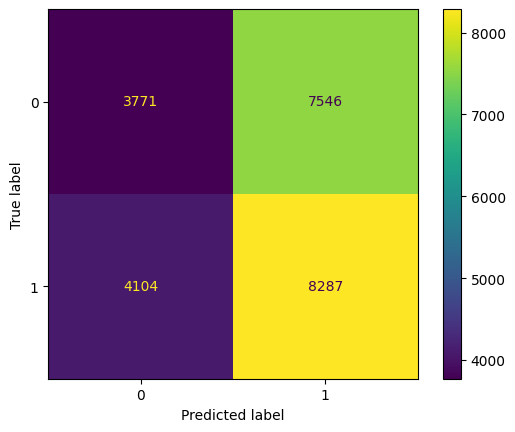

0.5086


In [12]:
reload_predict(M1a_gs, test_ds_gs, test_labels)

### VGG-16 Model 1a-gs: Grayscale + Unfrozen layers

In [13]:
M1a_gs_unf = keras.models.load_model("GC weights/Unfrozen/mod1a-gs/mod1a_gs_unfrozen.h5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_1 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 138,359,576
Trainable params: 138,359,576
Non-trainable params: 0
_________________________________________________________________
186/186 [==============================] - 25s 133ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.65     11317
          

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


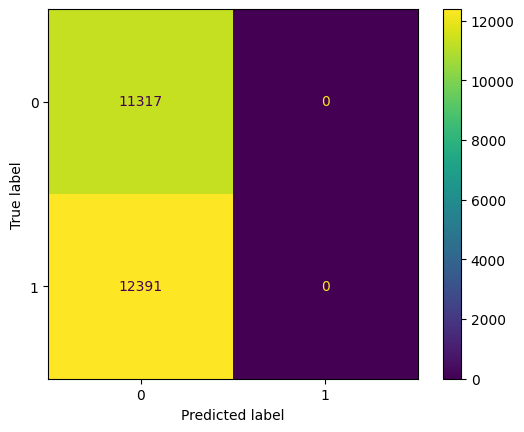

0.4773


In [14]:
reload_predict(M1a_gs_unf, test_ds_gs, test_labels)

### VGG-16 Model 1b-gs: Grayscale + Frozen layers

In [15]:
# Recreate model instance
M1b_gs = keras.models.load_model('GC weights/Frozen/mod1b-gs/mod1b_gs_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 138,359,576
Trainable params: 2,032
Non-trainable params: 138,357,544
_________________________________________________________________
186/186 [==============================] - 25s 135ms/step
              precision    recall  f1-score   support

           0       0.48      0.37      0.42     11317
        

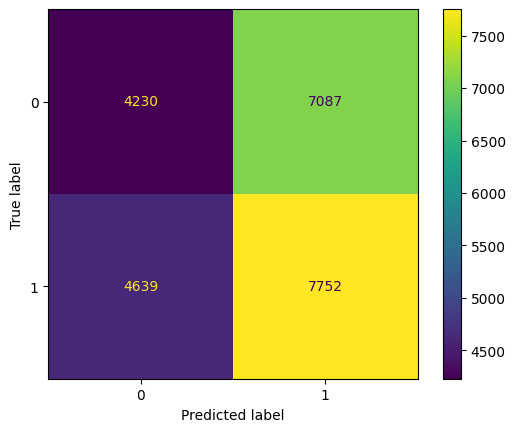

0.5054


In [16]:
reload_predict(M1b_gs, test_ds_gs, test_labels)

### VGG-16 Model 1b-gs: Grayscale + Unfrozen layers

In [17]:
# Recreate model instance
M1b_gs_unf = keras.models.load_model('GC weights/Unfrozen/mod1b-gs/mod1b_gs_unfrozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 138,358,575
Trainable params: 138,358,575
Non-trainable params: 0
_________________________________________________________________
186/186 [==============================] - 25s 134ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.65     11317
           1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


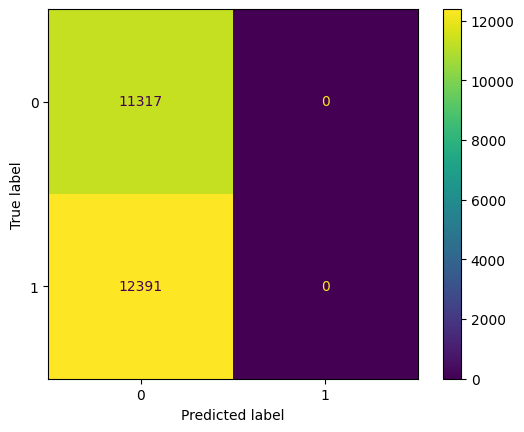

0.4773


In [18]:
reload_predict(M1b_gs_unf, test_ds_gs, test_labels)

### VGG-16 Model 1a-RGB: RGB + Frozen layers

In [19]:
M1a_rgb = keras.models.load_model('GC weights/Frozen/mod1a-RGB/mod1a_RGB_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 138,359,546
Trainable params: 2,002
Non-trainable params: 138,357,544
_________________________________________________________________
186/186 [==============================] - 29s 155ms/step
              precision    recall  f1-score   support

           0       0.48      0.58      0.52     11317
           1       0.52      0.42      0.46     12391

    accuracy                           0.49     23708
   macro avg       0.50      0.

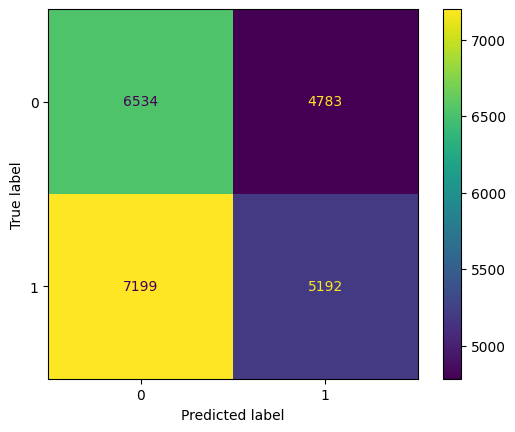

0.4946


In [20]:
reload_predict(M1a_rgb, test_ds_rgb, test_labels)

### VGG-16 Model 1a-RGB: RGB + Unfrozen layers

In [21]:
M1a_rgb_unf = keras.models.load_model('GC weights/Unfrozen/mod1a-RGB/mod1a_RGB_unfrozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 138,359,546
Trainable params: 138,359,546
Non-trainable params: 0
_________________________________________________________________
186/186 [==============================] - 28s 151ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11317
           1       0.52      1.00      0.69     12391

    accuracy                           0.52     23708
   macro avg       0.26      0.50  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


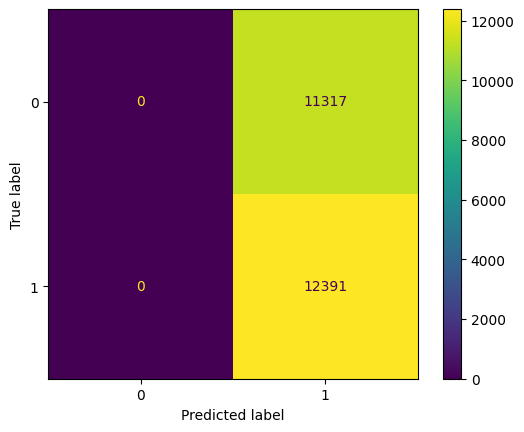

0.5227


In [22]:
reload_predict(M1a_rgb_unf, test_ds_rgb, test_labels)

### VGG-16 Model 1b-RGB: RGB + Frozen layers

In [23]:
# Recreate model instance
M1b_rgb = keras.models.load_model('GC weights/Frozen/mod1b-RGB/mod1b_RGB_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 138,359,546
Trainable params: 2,002
Non-trainable params: 138,357,544
_________________________________________________________________
186/186 [==============================] - 29s 153ms/step
              precision    recall  f1-score   support

           0       0.48      0.43      0.45     11317
           1       0.52      0.57      0.55     12391

    accuracy                           0.50     23708
   macro avg       0.50      0.

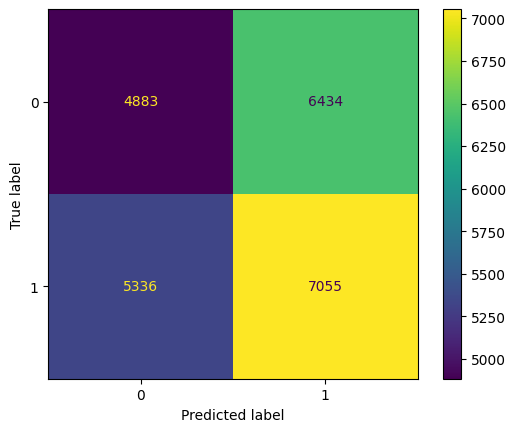

0.5035


In [24]:
reload_predict(M1b_rgb, test_ds_rgb, test_labels)

### VGG-16 Model 1b-RGB: RGB + Unfrozen layers

In [25]:
# Recreate model instance
M1b_rgb_unf = keras.models.load_model('GC weights/Unfrozen/mod1b-RGB/mod1b_RGB_unfrozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 138,358,545
Trainable params: 138,358,545
Non-trainable params: 0
_________________________________________________________________
186/186 [==============================] - 29s 156ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.65     11317
           1       0.00      0.00      0.00     12391

    accuracy                           0.48     23708
   macro avg       0.24      0.50  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


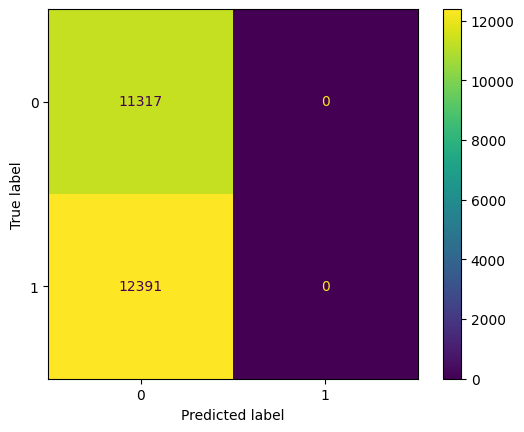

0.4773


In [26]:
reload_predict(M1b_rgb_unf, test_ds_rgb, test_labels)

### VGG-16 Model 1c-RGB: RGB (98, 76) images + All frozen layers except last 5

In [27]:
# Recreate model instance
M1c_rgb = keras.models.load_model('GC weights/abhilasha/mod1c-RGB/mod1c_RGB_frozen.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 14,781,122
Trainable params: 7,145,602
Non-trainable params: 7,635,520
_________________________________________________________________
186/186 [==============================] - 29s 153ms/step
              precision    recall  f1-score  

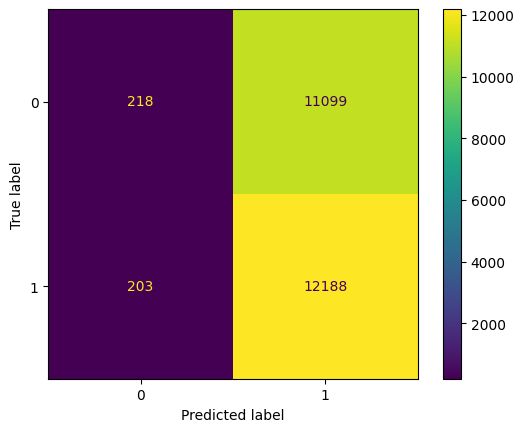

0.5233


In [28]:
reload_predict(M1c_rgb, test_ds_rgb, test_labels)

### Basic CNN Model 2a-RGB: RGB + No frozen Layers

In [29]:
# Recreate model instance
M2a_rgb = keras.models.load_model('GC weights/Unfrozen/mod2a-RGB/mod2a_RGB.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

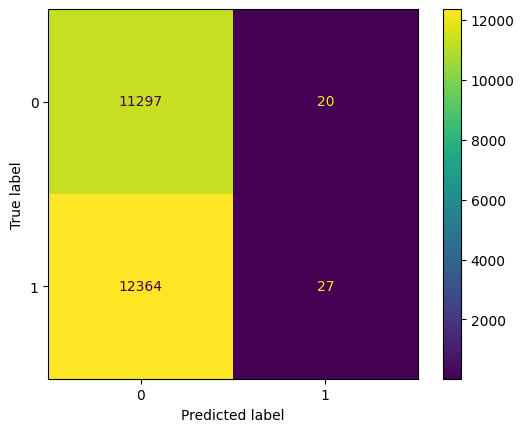

0.4776


In [30]:
reload_predict(M2a_rgb, test_ds_rgb, test_labels)

### Basic CNN Model 2b-RGB: RGB + No frozen Layers

In [31]:
# Recreate model instance
M2b_rgb = keras.models.load_model('GC weights/Unfrozen/mod2b-RGB/mod2b_RGB.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

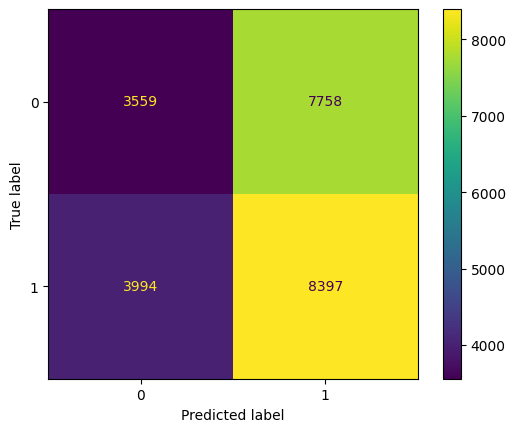

0.5043


In [32]:
reload_predict(M2b_rgb, test_ds_rgb, test_labels)

### Basic CNN Model 2a-gs: Grayscale + No frozen Layers

In [33]:
# Recreate model instance
M2a_gs = keras.models.load_model('GC weights/Unfrozen/mod2a-gs/mod2a_gs.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 3)  30          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  896         ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


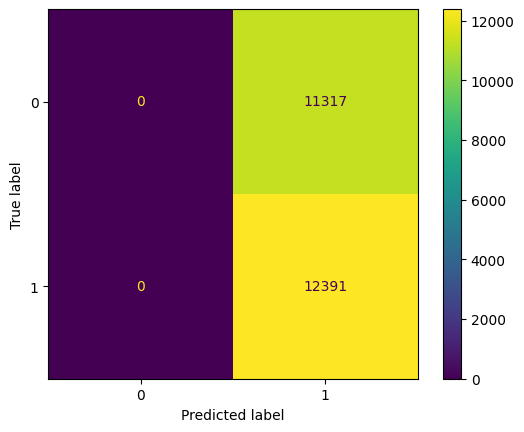

0.5227


In [34]:
reload_predict(M2a_gs, test_ds_gs, test_labels)

### Basic CNN Model 2b-gs: Grayscale + No frozen Layers

In [35]:
# Recreate model instance
M2b_gs = keras.models.load_model('GC weights/Unfrozen/mod2b-gs/mod2b_gs.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 3)  30          ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  896         ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

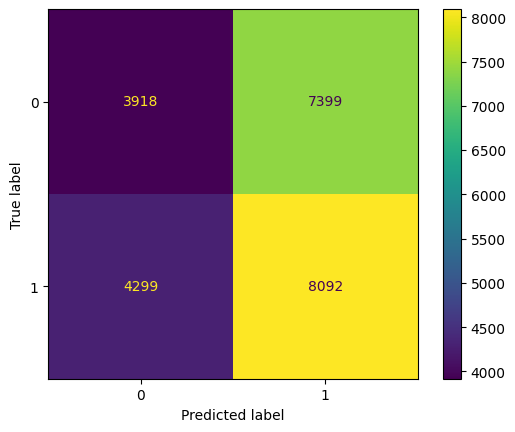

0.5066


In [36]:
reload_predict(M2b_gs, test_ds_gs, test_labels)

### DenseNet201 Model 3a-RGB: RGB + Frozen Layers

In [37]:
# Recreate model instance
M3a_rgb = keras.models.load_model('GC weights/Frozen/mod3a-RGB/mod3a_RGB_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1000)              20242984  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 20,244,986
Trainable params: 2,002
Non-trainable params: 20,242,984
_________________________________________________________________
186/186 [==============================] - 42s 217ms/step
              precision    recall  f1-score   support

           0       0.49      0.07      0.13     11317
           1       0.52      0.93      0.67     12391

    accuracy                           0.52     23708
   macro avg       0.51      0.50

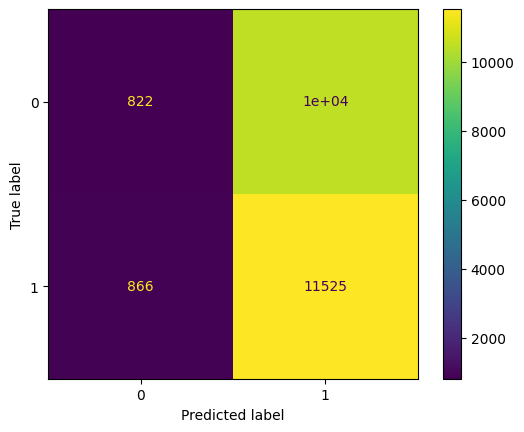

0.5208


In [38]:
reload_predict(M3a_rgb, test_ds_rgb, test_labels)

### DenseNet201 Model 3b-RGB: RGB + Frozen Layers

In [39]:
# Recreate model instance
M3b_rgb = keras.models.load_model('GC weights/Frozen/mod3b-RGB/mod3b_RGB_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1000)              20242984  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 20,244,986
Trainable params: 2,002
Non-trainable params: 20,242,984
_________________________________________________________________
186/186 [==============================] - 42s 217ms/step
              precision    recall  f1-score   support

           0       0.47      0.30      0.37     11317
           1       0.52      0.69      0.60     12391

    accuracy                           0.51     23708
   macro avg       0.50      0.50

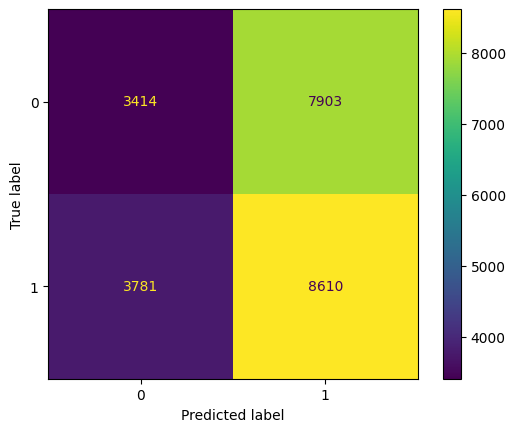

0.5072


In [40]:
reload_predict(M3b_rgb, test_ds_rgb, test_labels)

### DenseNet201 Model 3a-gs: Grayscale + Frozen Layers

In [41]:
# Recreate model instance
M3a_gs = keras.models.load_model('GC weights/Frozen/mod3a-gs/mod3a_gs_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 densenet201 (Functional)    (None, 1000)              20242984  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 20,245,016
Trainable params: 2,032
Non-trainable params: 20,242,984
_________________________________________________________________
186/186 [==============================] - 39s 198ms/step
              precision    recall  f1-score   support

           0       0.48      0.58      0.52     11317
          

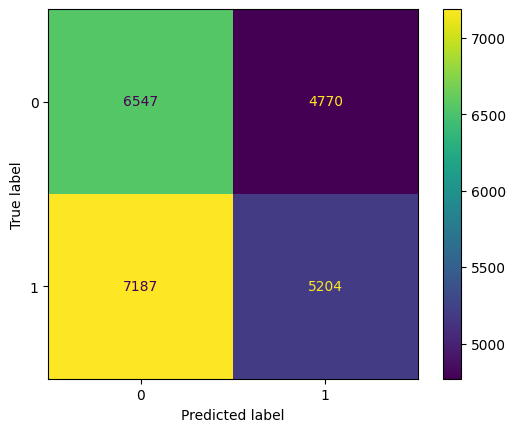

0.4957


In [42]:
reload_predict(M3a_gs, test_ds_gs, test_labels)

### DenseNet201 Model 3b-gs: Grayscale + Frozen Layers

In [43]:
# Recreate model instance
M3b_gs = keras.models.load_model('GC weights/Frozen/mod3b-gs/mod3b_gs_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 densenet201 (Functional)    (None, 1000)              20242984  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 20,245,016
Trainable params: 2,032
Non-trainable params: 20,242,984
_________________________________________________________________
186/186 [==============================] - 39s 198ms/step
              precision    recall  f1-score   support

           0       0.47      0.15      0.23     11317
          

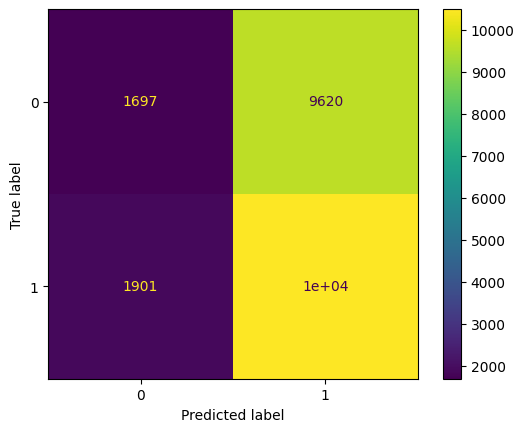

0.514


In [44]:
reload_predict(M3b_gs, test_ds_gs, test_labels)